Found 4504 images belonging to 2 classes.
Found 1126 images belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 128s 727ms/step - accuracy: 0.7557 - loss: 0.5384 - val_accuracy: 0.8561 - val_loss: 0.3592
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.8761 - loss: 0.3114 - val_accuracy: 0.8623 - val_loss: 0.3396
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 350ms/step - accuracy: 0.8900 - loss: 0.2930 - val_accuracy: 0.8535 - val_loss: 0.3485
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 286ms/step - accuracy: 0.9013 - loss: 0.2670 - val_accuracy: 0.8748 - val_loss: 0.3270
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.9028 - loss: 0.2443 - val_accuracy: 0.8783 - val_loss: 0.3114
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.9046 - loss: 0.2606 - val_accuracy: 0.8810 - val_loss: 0.3111
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - accuracy: 0.9110 - loss: 0.2412 - val_accuracy: 0.8863 - val_loss: 0.2986
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 282ms/step - accuracy: 0.9009 - loss: 0.2558 - va

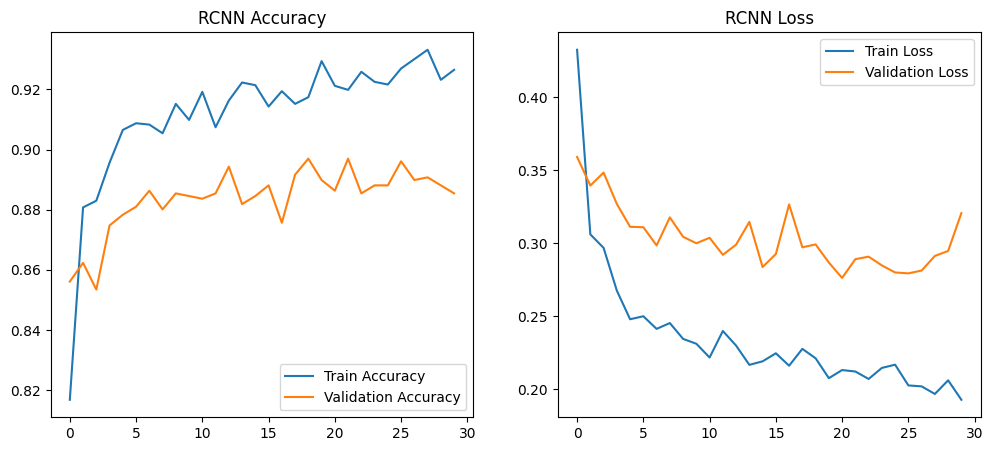

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9035 - loss: 0.2934
Test Accuracy: 0.89


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Lambda
)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def custom_preprocess_image(image):
    # Convert image to grayscale if it's not already
    if image.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
        image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
    
    # Standardize the image
    image = tf.image.per_image_standardization(image)

    # Perform histogram equalization on the grayscale image
    image = tf.image.adjust_gamma(image, gamma=1.0)  # Simple adjustment as an example
    # Note: More complex histogram equalization can be implemented if needed
    
    # Convert grayscale (1 channel) to 3 channels by duplicating the channel
    image = tf.image.grayscale_to_rgb(image)  # Now shape will be (height, width, 3)

    return image

# Dataset Paths (adjust these for your Kaggle environment)
train_dir = "/kaggle/input/major-project/Train/Train"
test_dir = "/kaggle/input/major-project/Test/Test"

# Data Preprocessing with Augmentation
datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=custom_preprocess_image
)

datagen_test = ImageDataGenerator(rescale=1.0 / 255.0 , preprocessing_function=custom_preprocess_image)

train_gen = datagen_train.flow_from_directory(
    train_dir, target_size=(299, 299), batch_size=32, class_mode="binary", color_mode='grayscale'
)

test_gen = datagen_test.flow_from_directory(
    test_dir, target_size=(299, 299), batch_size=32, class_mode="binary", shuffle=False, color_mode='grayscale'
)

# Register function to ensure compatibility with Keras serialization
@tf.keras.utils.register_keras_serializable()
def grayscale_to_rgb(x):
    """Repeat grayscale channel 3 times to convert it to RGB."""
    return tf.keras.backend.repeat_elements(x, 3, axis=-1)

# Define RCNN-Like Model with InceptionV3 Backbone
def build_rcnn_inception(input_shape=(299, 299, 1)):
    inputs = Input(shape=input_shape)
    
    # Convert grayscale to RGB by repeating the channel 3 times
    x = Lambda(grayscale_to_rgb)(inputs)
    
    # Use InceptionV3 as backbone
    backbone = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
    backbone.trainable = False  # Freeze all layers initially
    
    for layer in backbone.layers[-4:]:
        layer.trainable = True  # Unfreeze last few layers for fine-tuning
    
    x = backbone(x)
    x = GlobalAveragePooling2D()(x)  # GAP for better generalization
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation="sigmoid")(x)  # Binary classification
    
    model = Model(inputs, outputs)
    return model

# Build and Compile the Model
model = build_rcnn_inception(input_shape=(299, 299, 1))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the Model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,
    verbose=1
)

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("RCNN Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("RCNN Loss")
plt.show()

# Evaluate the Model
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the Model
model.save("/kaggle/working/rcnn_sar_oil_spill_inception.h5")

# Load the Model (for verification)
loaded_model = tf.keras.models.load_model(
    "/kaggle/working/rcnn_sar_oil_spill_inception.h5",
    custom_objects={"grayscale_to_rgb": grayscale_to_rgb}
)


**Prediction**

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import tensorflow as tf
import numpy as np

# Load the trained InceptionV3 model
@tf.keras.utils.register_keras_serializable()
def grayscale_to_rgb(x):
    """Repeat grayscale channel 3 times to convert it to RGB."""
    return tf.keras.backend.repeat_elements(x, 3, axis=-1)

model = tf.keras.models.load_model(
    "/kaggle/input/rcnn-inception-v3-model/rcnn_sar_oil_spill_inception.h5",
    custom_objects={"grayscale_to_rgb": grayscale_to_rgb}
)

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(299, 299), color_mode='grayscale')  # InceptionV3 uses 299x299
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return "Oil Spill" if prediction[0][0] > 0.5 else "No Oil Spill"

# Test the prediction function
sample_image_path = "/kaggle/input/sampleoilspill/Samples/0_0_0_img_ca9QOv0U0q6eU9Ow_PHI_cls_0.jpg"  # Adjust path
print(f"Prediction: {predict_image(model, sample_image_path)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediction: No Oil Spill


Found 1126 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step


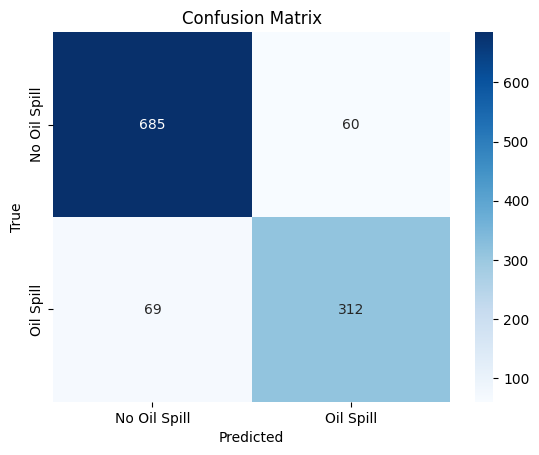

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       745
           1       0.84      0.82      0.83       381

    accuracy                           0.89      1126
   macro avg       0.87      0.87      0.87      1126
weighted avg       0.88      0.89      0.89      1126

Precision: 0.8387
Recall: 0.8189
F1 Score: 0.8287


In [6]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Load the trained InceptionV3 model
@tf.keras.utils.register_keras_serializable()
def grayscale_to_rgb(x):
    """Repeat grayscale channel 3 times to convert it to RGB."""
    return tf.keras.backend.repeat_elements(x, 3, axis=-1)

model = tf.keras.models.load_model(
    "/kaggle/input/rcnn-inception-v3-model/rcnn_sar_oil_spill_inception.h5",
    custom_objects={"grayscale_to_rgb": grayscale_to_rgb}
)

test_dir = "/kaggle/input/major-project/Test/Test"

# Data Preprocessing
datagen_test = ImageDataGenerator(rescale=1.0 / 255.0)

test_gen = datagen_test.flow_from_directory(
    test_dir, target_size=(299, 299), batch_size=32, class_mode="binary", shuffle=False, color_mode='grayscale'
)

# Predict the results on the test set
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No Oil Spill', 'Oil Spill'], yticklabels=['No Oil Spill', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
